In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

In [2]:
# SDOF Transient Response (ISO 18431-4)
# th_in : acceleration time history at base
# th_out : acceleration time history at mass
def SDOF_ISO(th_in,dt,fn,zeta):

    wn = 2*np.pi*fn;
    wd = wn*np.sqrt(1-zeta**2);
    A=wn*dt*zeta;
    B=wd*dt;
    
    a, b = np.zeros(3), np.zeros(3);

    b[0] = 1 - np.exp(-A)*np.sin(B)/B;
    b[1] = 2*np.exp(-A)*(np.sin(B)/B - np.cos(B));
    b[2] = np.exp(-2*A) - np.exp(-A) * np.sin(B)/B;

    a[0] = 1;
    a[1] = -2*np.exp(-A)*np.cos(B);
    a[2] = np.exp(-2*A);

    th_out=lfilter(b, a, th_in, axis=-1, zi=None);
    
    return th_out;

In [3]:
## SRS (ISO 18431-4)
def srs_iso(ft,th,dr,dt):
    nf = len(ft);
    rs = np.zeros(nf);
    for i in range(nf):
        rs[i]= max(abs(SDOF_ISO(th,dt,ft[i],dr)));
    return ft,rs;

In [4]:
# RG 1.60
ft = np.array([0.10,  2.50, 9.00, 33.0, 100.0]);  # frequency table
rt = np.array([0.07,  3.13, 2.61,  1.0,   1.0]);  # response spectrum table

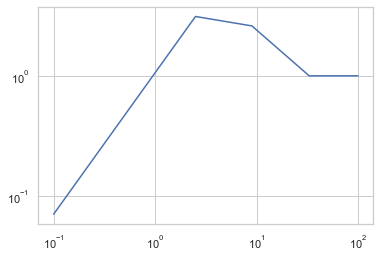

In [5]:
plt.loglog(ft,rt);

In [6]:
## frequency table 작성
# frequency 간격
noct = 1/3; # 1/6; # 1/12;
# frequency table 
fmin = min(ft); fmax = max(ft);
nfreq = int(np.ceil(np.log(fmax/fmin)/np.log(2)/noct))-1;
freq = np.zeros(nfreq);
freq[0] = fmin*(2**noct);
for i in range(1,nfreq):
    freq[i] = freq[i-1]*(2**noct);
freq = np.sort(np.concatenate([freq,ft]));
nfreq = len(freq);

In [7]:
## log-log interpolation
rs = 10**np.interp(np.log10(freq),np.log10(ft),np.log10(rt));

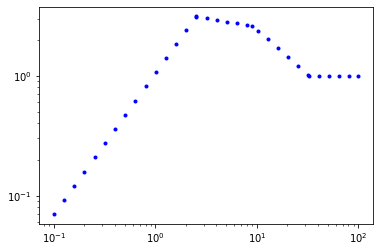

In [8]:
plt.loglog(freq,rs,'b.');

1. Sinusoidal 조합 형

$\ddot{x}(t) = I(t) \sum_n A_n sin(\omega_n t + \phi_n)$

In [6]:
def rs2th_sine(ft,rt,noct,damp,tmax,it):
    fmin = min(ft); fmax = max(ft);
    nfreq = int(np.ceil(np.log(fmax/fmin)/np.log(2)/noct))-1;
    freq = np.zeros(nfreq);
    freq[0] = fmin*(2**noct);
    for i in range(1,nfreq):
        freq[i] = freq[i-1]*(2**noct);
    freq = np.sort(np.concatenate([freq,ft]));
    nfreq = len(freq);    
    ## log-log interpolation
    rs = 10**np.interp(np.log10(freq),np.log10(ft),np.log10(rt));
    ## Initial TH
    An = np.copy(rs);
    wn = 2*np.pi*freq;
    phin = np.random.uniform(-np.pi/2,np.pi/2,nfreq);
    dt = 1/(20*fmax); t = np.arange(0,tmax+dt,dt);
    th = np.zeros(len(t));
    for i in range(len(t)):
        for j in range(nfreq):
            th[i] += An[j]*np.sin(wn[j]*t[i]+phin[j]);
    freq,rs_syn = srs_iso(freq,th,damp,dt);
    # Start Iteration
    trial = np.linspace(1,it,it); 
    error = np.zeros(it);
    for k in range(it):
        for i in range(nfreq):
            An[i] *= rs[i]/rs_syn[i];
        th = np.zeros(len(t));
        for i in range(len(t)):
            for j in range(nfreq):
                th[i] += An[j]*np.sin(wn[j]*t[i]+phin[j]);
        
        freq,rs_syn = srs_iso(freq,th,damp,dt);
    
        error[k] = np.linalg.norm(rs-rs_syn);
    return freq,rs,rs_syn,trial,error;

In [7]:
freq,rs,rs_syn,trial,error = rs2th_sine(ft,rt,1/6,0.05,5,20);

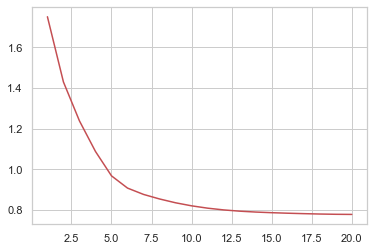

In [8]:
plt.plot(trial,error,'r-');

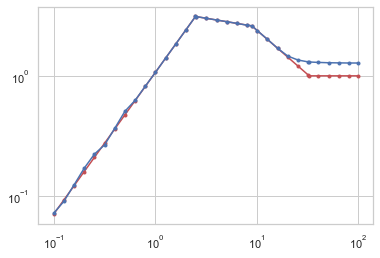

In [11]:
plt.loglog(freq,rs,'r.-');
plt.loglog(freq,rs_syn,'b.-');

2. Damped Sine 조합 형

$\ddot{x}(t) = \sum_n A_n e^{-\zeta*\omega_n*(t-t_d)} sin(\omega_n (t-t_d) )$

In [14]:
def damped_sine(t,amp,damp,w,td):
    if len(t)==1:
        if t < td:
            out = 0;
        else:
            out = amp*np.exp(-damp*w*(t-td))*np.sin(w*(t-td));
    else:
        out = np.zeros(len(t));
        for i in range(len(t)):
            if t[i] < td:
                out[i] = 0;
            else:
                out[i] = amp*np.exp(-damp*w*(t[i]-td))*np.sin(w*(t[i]-td));
    return out

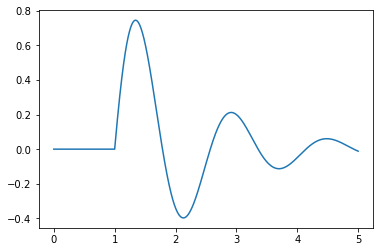

In [15]:
plt.plot(t,damped_sine(t,1,0.2,4,1));

3. Wavelet 조합형